In [57]:
# In this notebook i wanted to prepare a template for using Elmo at other projects. I tried very very simple samples for future reference.
#Elmo embeddings are learned from the internal state of a bidirectional LSTM and represent contextual features of the input text.
#Even ELMo, which uses a bidirectional LSTM, simply concatenated the left-to-right and right-to-left information,
#meaning that the representation couldn't take advantage of both left and right contexts simultaneously. 
#BERT replaces language modeling with a modified objective they called “masked language modeling”.

In [2]:


%tensorflow_version 1.5

In [3]:
# Import our dependencies
import tensorflow as tf
import pandas as pd
import tensorflow_hub as hub
import os
import re

from keras import backend as K
#import tensorflow.keras.backend as K

import keras.layers as layers
from keras.models import Model, load_model
from keras.engine import Layer
import numpy as np

# Initialize session
sess = tf.Session()
K.set_session(sess)

Using TensorFlow backend.


In [4]:
# Load all files from a directory in a DataFrame.
def load_directory_data(directory):
  data = {}
  data["sentence"] = []
  data["sentiment"] = []
  for file_path in os.listdir(directory):
    with tf.gfile.GFile(os.path.join(directory, file_path), "r") as f:
      data["sentence"].append(f.read())
      data["sentiment"].append(re.match("\d+_(\d+)\.txt", file_path).group(1))
  return pd.DataFrame.from_dict(data)

# Merge positive and negative examples, add a polarity column and shuffle.
def load_dataset(directory):
  pos_df = load_directory_data(os.path.join(directory, "pos"))
  neg_df = load_directory_data(os.path.join(directory, "neg"))
  pos_df["polarity"] = 1
  neg_df["polarity"] = 0
  return pd.concat([pos_df, neg_df]).sample(frac=1).reset_index(drop=True)

# Download and process the dataset files.
def download_and_load_datasets(force_download=False):
  dataset = tf.keras.utils.get_file(
      fname="aclImdb.tar.gz", 
      origin="http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz", 
      extract=True)

  train_df = load_dataset(os.path.join(os.path.dirname(dataset), 
                                       "aclImdb", "train"))
  test_df = load_dataset(os.path.join(os.path.dirname(dataset), 
                                      "aclImdb", "test"))

  return train_df, test_df

# Reduce logging output.
tf.logging.set_verbosity(tf.logging.ERROR)

train_df, test_df = download_and_load_datasets()
train_df.head()

,sentence,sentiment,polarity
0,I watched an episode. Yes I sat through the en...,1,0
1,Ludicrous violations of the most basic securit...,1,0
2,"""Trigger Man"" is definitely the most boring an...",1,0
3,"I'm sorry to all the fans, but this is a usele...",2,0
4,"In my mind, this remains one of the very best ...",10,1


In [5]:
# Create a custom layer that allows us to update weights (lambda layers do not have trainable parameters!)

class ElmoEmbeddingLayer(Layer):
    def __init__(self, **kwargs):
        self.dimensions = 1024
        self.trainable=True
        super(ElmoEmbeddingLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.elmo = hub.Module('https://tfhub.dev/google/elmo/2', trainable=self.trainable,
                               name="{}_module".format(self.name))

        self.trainable_weights += tf.trainable_variables(scope="^{}_module/.*".format(self.name))
        super(ElmoEmbeddingLayer, self).build(input_shape)

    def call(self, x, mask=None):
        result = self.elmo(K.squeeze(K.cast(x, tf.string), axis=1),
                      as_dict=True,
                      signature='default',
                      )['default']
        return result

    def compute_mask(self, inputs, mask=None):
        return K.not_equal(inputs, '--PAD--')

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.dimensions)

In [6]:
# Function to build model real model takes too much time to try
def build_model(): 
  input_text = layers.Input(shape=(1,), dtype="string")
  embedding = ElmoEmbeddingLayer()(input_text)
  dense = layers.Dense(256, activation='relu')(embedding)
  pred = layers.Dense(1, activation='sigmoid')(dense)

  model = Model(inputs=[input_text], outputs=pred)

  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  model.summary()
  
  return model

In [58]:
# just use model for embedding generation
def build_model_elmo(): 
  input_text = layers.Input(shape=(1,), dtype="string")
  embedding = ElmoEmbeddingLayer()(input_text)
  

  model = Model(inputs=[input_text], outputs=embedding)

  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  model.summary()
  
  return model

In [8]:


# Create datasets (Only take up to 150 words for memory)
train_text = train_df['sentence'].tolist()
train_text = [' '.join(t.split()[0:150]) for t in train_text]
train_text = np.array(train_text, dtype=object)[:, np.newaxis]
train_label = train_df['polarity'].tolist()

test_text = test_df['sentence'].tolist()
test_text = [' '.join(t.split()[0:150]) for t in test_text]
test_text = np.array(test_text, dtype=object)[:, np.newaxis]
test_label = test_df['polarity'].tolist()



In [9]:
# Build and fit
model = build_model()


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
elmo_embedding_layer_1 (Elmo (None, 1024)              4         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               262400    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 262,661
Trainable params: 262,661
Non-trainable params: 0
_________________________________________________________________


In [10]:
sample = train_text[0]
print("sample : ", sample)

sample :  ["I watched an episode. Yes I sat through the entire miserable experience, and I have to say, this brand of comedy is one of the worst you will get. Imagine Peter Griffin, of Family Guy fame. Now imagine Peter Griffin as a(admittedly slim and minus the glasses) woman, except that he now lacks the something that made him hilarious. Peter Griffin is an idiot, but he doesn't know he's an idiot. Sarah has none of the genuine character, none of the acting ability to pull her character off. Maybe its the trite, formulaic jokes that pull her comedy even lower than her character can take it by herself. Maybe it's the lack of believable foils. Her insensitive, bigoted persona may appeal to insensitive, bigoted people unlike the mass appeal that Stephen Colbert's insensitive, bigoted character has. Like Bill O'Reilly, Sarah creates an annoying, unfunny character. She lacks something that is"]


In [11]:
model_elmo = build_model_elmo()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
elmo_embedding_layer_2 (Elmo (None, 1024)              4         
Total params: 4
Trainable params: 4
Non-trainable params: 0
_________________________________________________________________


In [12]:
model_elmo.fit([train_text[0]], 
           np.zeros(1024).reshape(1,1024),          
          epochs=2)

Epoch 1/2
1/1 [==============================] - 5s 5s/step - loss: 0.1182 - accuracy: 0.9727
Epoch 2/2
1/1 [==============================] - 5s 5s/step - loss: 0.1180 - accuracy: 0.9727


In [15]:
elmo_result = model_elmo.predict(np.array(["test sentence for train"]))
print( np.sum(elmo_result.squeeze() ))

0.038292408


In [16]:
elmo_result = model_elmo.predict(np.array(["sentence for train Test"]))
print( np.sum(elmo_result.squeeze() ))

-1.494627


In [17]:
elmo_result = model_elmo.predict(np.array(["sentence sentence sentence Test"]))
print( np.sum(elmo_result.squeeze() ))

14.945867


In [18]:
elmo_result = model_elmo.predict(np.array(["Test sentence sentence sentence"]))
print( np.sum(elmo_result.squeeze() ))

6.301589


In [19]:
elmo_result = model_elmo.predict(np.array(["Test sentence"]))
print( np.sum(elmo_result.squeeze() ))

-4.333769


In [23]:
elmo_result = model_elmo.predict(np.array(["sentence traintest target"]))
print( np.sum(elmo_result.squeeze() ))

11.476492


In [54]:
import itertools

def get_combination_set(inputs):
  all_set = []
  for comb in itertools.permutations(inputs, len(inputs)):
    #print(comb)
    all_set.append(" ".join(comb)) 
  return all_set   


#set1 = [ "sentence","train","test"]
#set1_sentences = get_combination_set(set1)

#set1 = [ "sentence","train","test","validation"]
#set1_sentences = get_combination_set(set1)*/
tsets = []
tsets.append( [ "sentence","train","test"] )
tsets.append( [ "sentence","train","validation"] )
tsets.append( [ "country","city","history"] )


xs = []
ys = []
for index,tset in enumerate(tsets) :
  set_sentences = get_combination_set(tset)
  for s in set_sentences:
    #print(s)
    xs.append( model_elmo.predict( np.array( [s] ) ) )
    ys.append(index)



In [55]:
print( np.array(xs ).shape )
xs = [ x.flatten() for x in xs]
print( np.array(xs ).shape )

(18, 1, 1024)
(18, 1024)


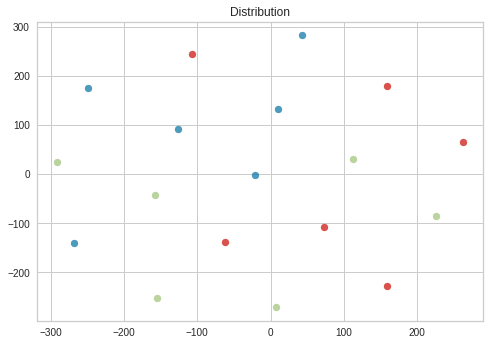

In [56]:
from yellowbrick.text import TSNEVisualizer

tsne = TSNEVisualizer()
tsne.fit(xs, ys)
tsne.labels= ["1","2","3"]
tsne.colors = ["black","yellow","green"]
tsne.set_title("Distribution")